## Setup

# Tensorflow Road Signs YOLO Debugging Notebook

In [1]:
import json
from pathlib import Path

# Import third-party Python packages
import numpy as np
import imgaug as ia
from pycocotools.coco import COCO
from pycocotools.cocoeval import COCOeval

# Import utils.py file
import utils

# Import training script objects
from scripts.speedlimit_only_dataset import load_xml, extract_roadsigns_annotation_data_from_xml
from train_script import input_image_shape, efficientnet_model, efficientnet_bbox_nms, efficientnet_testing_bbox_nms, efficientnet_testing_data, efficientnet_testing_data_filepaths, get_predicted_bbox_images, efficientnet_bbox_confluence, efficientnet_testing_bbox_confluence, TensorflowBoundingBoxesYOLOV1Confluence
from mitre.securingai.sdk.utilities.logging import configure_structlog, set_logging_level

# Create random number generator
rng = np.random.default_rng(54399264723942495723666216079516778448)

set_logging_level("INFO")
configure_structlog()


2022-03-22 10:51:28.814204: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
CHECKPOINTS_DIR = Path("checkpoints")
MODELS_DIR = Path("models") / "efficientnetb1_twoheaded"
PATCHES_DIR = Path("patches")
# RESULTS_JSON_FILE = Path("roadsigns_results.json")
RESULTS_JSON_FILE = Path("roadsigns-224x224x3-yolov1-efficientnetb1-twoheaded-finetuned-weights-predictions-all.json")
PATCHED_RESULTS_JSON_FILE = Path("roadsigns_patched_results.json")
PATCHED_SPINDLE10_RESULTS_JSON_FILE = Path("roadsigns_patched_spindle10_results.json")
PATCHED_SPINDLE20_RESULTS_JSON_FILE = Path("roadsigns_patched_spindle20_results.json")
PATCHED_SPINDLE30_RESULTS_JSON_FILE = Path("roadsigns_patched_spindle30_results.json")
PATCHED_DPATCH10_RESULTS_JSON_FILE = Path("roadsigns_patched_dpatch10_results.json")
PATCHED_DPATCH20_RESULTS_JSON_FILE = Path("roadsigns_patched_dpatch20_results.json")
PATCHED_ROBUST_DPATCH1785_RESULTS_JSON_FILE = Path("roadsigns_patched_robust_dpatch1785_results.json")
COCO_LABELS_FILE = Path("data") / "Road-Sign-Detection-v2" / "coco.json"

MODEL_WEIGHTS = MODELS_DIR / "roadsigns-448x448x3-yolov1-efficientnetb1-twoheaded-finetuned-weights.hdf5"
# MODEL_WEIGHTS = CHECKPOINTS_DIR / "train3-weights.100-0.393.hdf5"

IMAGENET_PATCHES_DIR = PATCHES_DIR / "imagenet_patches"
PAPER_PATCHES_DIR = PATCHES_DIR / "paper_patches"
VIVID_IMAGENET_PATCHES_DIR = PATCHES_DIR / "vivid_imagenet_patches"

In [3]:
efficientnet_model.build((None, input_image_shape[0], input_image_shape[1], input_image_shape[2]))
efficientnet_model.backbone.trainable = True
efficientnet_model.load_weights(str(MODEL_WEIGHTS))

In [ ]:
full_patched_spindle10_coco_results = []
iterations_count = 0
predictions_for_metrics_spindle10 = get_predicted_bbox_images(efficientnet_testing_data, efficientnet_model, input_image_shape, efficientnet_testing_bbox_nms, VIVID_IMAGENET_PATCHES_DIR / "imagenet_patch_7_target_spindle.png", 0.1, efficientnet_testing_data_filepaths)

while True:
    try:
        pred_image, pred_boxes, pred_scores, pred_labels, pred_num_detections, pred_conf, pred_labels_proba, coco_results = next(predictions_for_metrics_spindle10)
        patched_pred_image, patched_pred_boxes, patched_pred_scores, patched_pred_labels, patched_pred_num_detections, patched_pred_conf, patched_pred_labels_proba, patched_coco_results = next(predictions_for_metrics_spindle10)
        xml_annotations_filepath = Path("data") / "Road-Sign-Detection-v2" / "annotations" / Path(efficientnet_testing_data_filepaths[iterations_count]).with_suffix(".xml").name
        xml_annotation_data = extract_roadsigns_annotation_data_from_xml(load_xml(xml_annotations_filepath)[1])
        img_width = int(xml_annotation_data["image_width"])
        img_height = int(xml_annotation_data["image_height"])

        # for result in coco_results:
        #     bbox = [result["bbox"][0] * img_width, result["bbox"][1] * img_height, result["bbox"][2] * img_width, result["bbox"][3] * img_height]
        #     result["bbox"] = bbox

        for result in patched_coco_results:
            bbox = [result["bbox"][0] * img_width, result["bbox"][1] * img_height, result["bbox"][2] * img_width, result["bbox"][3] * img_height]
            result["bbox"] = bbox

        full_patched_spindle10_coco_results.extend(patched_coco_results)

        if iterations_count % 10 == 0:
            print(iterations_count)

        iterations_count += 1

    except (StopIteration, IndexError):
        break

full_patched_spindle10_coco_results2 = []

for result in full_patched_spindle10_coco_results:
    if not result["score"] < 1e-6:
        result_dict = {}
        for k, v in result.items():
            if k == "category_id":
                result_dict[k] = int(v)

            elif k == "image_id":
                result_dict[k] = int(v)

            elif k == "bbox":
                result_dict[k] = [round(float(x), 1) for x in v]

            elif k == "score":
                result_dict[k] = round(float(v), 6)

            else:
                result_dict[k] = v

        full_patched_spindle10_coco_results2.append(result_dict)

full_patched_spindle10_coco_results2 = sorted(full_patched_spindle10_coco_results2, key=lambda x: (x["image_id"], x["score"]))

with PATCHED_SPINDLE10_RESULTS_JSON_FILE.open("wt") as f:
    json.dump(obj=full_patched_spindle10_coco_results2, fp=f)


In [ ]:
full_patched_spindle20_coco_results = []
iterations_count = 0
predictions_for_metrics_spindle20 = get_predicted_bbox_images(efficientnet_testing_data, efficientnet_model, input_image_shape, efficientnet_testing_bbox_nms, VIVID_IMAGENET_PATCHES_DIR / "imagenet_patch_7_target_spindle.png", 0.2, efficientnet_testing_data_filepaths)

while True:
    try:
        pred_image, pred_boxes, pred_scores, pred_labels, pred_num_detections, pred_conf, pred_labels_proba, coco_results = next(predictions_for_metrics_spindle20)
        patched_pred_image, patched_pred_boxes, patched_pred_scores, patched_pred_labels, patched_pred_num_detections, patched_pred_conf, patched_pred_labels_proba, patched_coco_results = next(predictions_for_metrics_spindle20)
        xml_annotations_filepath = Path("data") / "Road-Sign-Detection-v2" / "annotations" / Path(efficientnet_testing_data_filepaths[iterations_count]).with_suffix(".xml").name
        xml_annotation_data = extract_roadsigns_annotation_data_from_xml(load_xml(xml_annotations_filepath)[1])
        img_width = int(xml_annotation_data["image_width"])
        img_height = int(xml_annotation_data["image_height"])

        # for result in coco_results:
        #     bbox = [result["bbox"][0] * img_width, result["bbox"][1] * img_height, result["bbox"][2] * img_width, result["bbox"][3] * img_height]
        #     result["bbox"] = bbox

        for result in patched_coco_results:
            bbox = [result["bbox"][0] * img_width, result["bbox"][1] * img_height, result["bbox"][2] * img_width, result["bbox"][3] * img_height]
            result["bbox"] = bbox

        full_patched_spindle20_coco_results.extend(patched_coco_results)

        if iterations_count % 10 == 0:
            print(iterations_count)

        iterations_count += 1

    except (StopIteration, IndexError):
        break

full_patched_spindle20_coco_results2 = []

for result in full_patched_spindle20_coco_results:
    if not result["score"] < 1e-6:
        result_dict = {}
        for k, v in result.items():
            if k == "category_id":
                result_dict[k] = int(v)

            elif k == "image_id":
                result_dict[k] = int(v)

            elif k == "bbox":
                result_dict[k] = [round(float(x), 1) for x in v]

            elif k == "score":
                result_dict[k] = round(float(v), 6)

            else:
                result_dict[k] = v

        full_patched_spindle20_coco_results2.append(result_dict)

full_patched_spindle20_coco_results2 = sorted(full_patched_spindle20_coco_results2, key=lambda x: (x["image_id"], x["score"]))

with PATCHED_SPINDLE20_RESULTS_JSON_FILE.open("wt") as f:
    json.dump(obj=full_patched_spindle20_coco_results2, fp=f)


In [ ]:
full_patched_dpatch10_coco_results = []
iterations_count = 0
predictions_for_metrics_dpatch10 = get_predicted_bbox_images(efficientnet_testing_data, efficientnet_model, input_image_shape, efficientnet_testing_bbox_nms, PATCHES_DIR / "dpatch.png", 0.2, efficientnet_testing_data_filepaths)

while True:
    try:
        pred_image, pred_boxes, pred_scores, pred_labels, pred_num_detections, pred_conf, pred_labels_proba, coco_results = next(predictions_for_metrics_dpatch10)
        patched_pred_image, patched_pred_boxes, patched_pred_scores, patched_pred_labels, patched_pred_num_detections, patched_pred_conf, patched_pred_labels_proba, patched_coco_results = next(predictions_for_metrics_dpatch10)
        xml_annotations_filepath = Path("data") / "Road-Sign-Detection-v2" / "annotations" / Path(efficientnet_testing_data_filepaths[iterations_count]).with_suffix(".xml").name
        xml_annotation_data = extract_roadsigns_annotation_data_from_xml(load_xml(xml_annotations_filepath)[1])
        img_width = int(xml_annotation_data["image_width"])
        img_height = int(xml_annotation_data["image_height"])

        # for result in coco_results:
        #     bbox = [result["bbox"][0] * img_width, result["bbox"][1] * img_height, result["bbox"][2] * img_width, result["bbox"][3] * img_height]
        #     result["bbox"] = bbox

        for result in patched_coco_results:
            bbox = [result["bbox"][0] * img_width, result["bbox"][1] * img_height, result["bbox"][2] * img_width, result["bbox"][3] * img_height]
            result["bbox"] = bbox

        full_patched_dpatch10_coco_results.extend(patched_coco_results)

        if iterations_count % 10 == 0:
            print(iterations_count)

        iterations_count += 1

    except (StopIteration, IndexError):
        break

full_patched_dpatch10_coco_results2 = []

for result in full_patched_dpatch10_coco_results:
    if not result["score"] < 1e-6:
        result_dict = {}
        for k, v in result.items():
            if k == "category_id":
                result_dict[k] = int(v)

            elif k == "image_id":
                result_dict[k] = int(v)

            elif k == "bbox":
                result_dict[k] = [round(float(x), 1) for x in v]

            elif k == "score":
                result_dict[k] = round(float(v), 6)

            else:
                result_dict[k] = v

        full_patched_dpatch10_coco_results2.append(result_dict)

full_patched_dpatch10_coco_results2 = sorted(full_patched_dpatch10_coco_results2, key=lambda x: (x["image_id"], x["score"]))

with PATCHED_DPATCH10_RESULTS_JSON_FILE.open("wt") as f:
    json.dump(obj=full_patched_dpatch10_coco_results2, fp=f)


In [ ]:
full_patched_dpatch20_coco_results = []
iterations_count = 0
predictions_for_metrics_dpatch20 = get_predicted_bbox_images(efficientnet_testing_data, efficientnet_model, input_image_shape, efficientnet_testing_bbox_nms, PATCHES_DIR / "dpatch.png", 0.2, efficientnet_testing_data_filepaths)

while True:
    try:
        pred_image, pred_boxes, pred_scores, pred_labels, pred_num_detections, pred_conf, pred_labels_proba, coco_results = next(predictions_for_metrics_dpatch20)
        patched_pred_image, patched_pred_boxes, patched_pred_scores, patched_pred_labels, patched_pred_num_detections, patched_pred_conf, patched_pred_labels_proba, patched_coco_results = next(predictions_for_metrics_dpatch20)
        xml_annotations_filepath = Path("data") / "Road-Sign-Detection-v2" / "annotations" / Path(efficientnet_testing_data_filepaths[iterations_count]).with_suffix(".xml").name
        xml_annotation_data = extract_roadsigns_annotation_data_from_xml(load_xml(xml_annotations_filepath)[1])
        img_width = int(xml_annotation_data["image_width"])
        img_height = int(xml_annotation_data["image_height"])

        # for result in coco_results:
        #     bbox = [result["bbox"][0] * img_width, result["bbox"][1] * img_height, result["bbox"][2] * img_width, result["bbox"][3] * img_height]
        #     result["bbox"] = bbox

        for result in patched_coco_results:
            bbox = [result["bbox"][0] * img_width, result["bbox"][1] * img_height, result["bbox"][2] * img_width, result["bbox"][3] * img_height]
            result["bbox"] = bbox

        full_patched_dpatch20_coco_results.extend(patched_coco_results)

        if iterations_count % 10 == 0:
            print(iterations_count)

        iterations_count += 1

    except (StopIteration, IndexError):
        break

full_patched_dpatch20_coco_results2 = []

for result in full_patched_dpatch20_coco_results:
    if not result["score"] < 1e-6:
        result_dict = {}
        for k, v in result.items():
            if k == "category_id":
                result_dict[k] = int(v)

            elif k == "image_id":
                result_dict[k] = int(v)

            elif k == "bbox":
                result_dict[k] = [round(float(x), 1) for x in v]

            elif k == "score":
                result_dict[k] = round(float(v), 6)

            else:
                result_dict[k] = v

        full_patched_dpatch20_coco_results2.append(result_dict)

full_patched_dpatch20_coco_results2 = sorted(full_patched_dpatch20_coco_results2, key=lambda x: (x["image_id"], x["score"]))

with PATCHED_DPATCH20_RESULTS_JSON_FILE.open("wt") as f:
    json.dump(obj=full_patched_dpatch20_coco_results2, fp=f)


In [ ]:
full_patched_robust_dpatch1785_coco_results = []
iterations_count = 0
predictions_for_metrics_robust_dpatch1785 = get_predicted_bbox_images(efficientnet_testing_data, efficientnet_model, input_image_shape, efficientnet_testing_bbox_nms, PATCHES_DIR / "robust_dpatch1.png", 0.1785, efficientnet_testing_data_filepaths)

while True:
    try:
        pred_image, pred_boxes, pred_scores, pred_labels, pred_num_detections, pred_conf, pred_labels_proba, coco_results = next(predictions_for_metrics_robust_dpatch1785)
        patched_pred_image, patched_pred_boxes, patched_pred_scores, patched_pred_labels, patched_pred_num_detections, patched_pred_conf, patched_pred_labels_proba, patched_coco_results = next(predictions_for_metrics_robust_dpatch1785)
        xml_annotations_filepath = Path("data") / "Road-Sign-Detection-v2" / "annotations" / Path(efficientnet_testing_data_filepaths[iterations_count]).with_suffix(".xml").name
        xml_annotation_data = extract_roadsigns_annotation_data_from_xml(load_xml(xml_annotations_filepath)[1])
        img_width = int(xml_annotation_data["image_width"])
        img_height = int(xml_annotation_data["image_height"])

        # for result in coco_results:
        #     bbox = [result["bbox"][0] * img_width, result["bbox"][1] * img_height, result["bbox"][2] * img_width, result["bbox"][3] * img_height]
        #     result["bbox"] = bbox

        for result in patched_coco_results:
            bbox = [result["bbox"][0] * img_width, result["bbox"][1] * img_height, result["bbox"][2] * img_width, result["bbox"][3] * img_height]
            result["bbox"] = bbox

        full_patched_robust_dpatch1785_coco_results.extend(patched_coco_results)

        if iterations_count % 10 == 0:
            print(iterations_count)

        iterations_count += 1

    except (StopIteration, IndexError):
        break

full_patched_robust_dpatch1785_coco_results2 = []

for result in full_patched_robust_dpatch1785_coco_results:
    if not result["score"] < 1e-6:
        result_dict = {}
        for k, v in result.items():
            if k == "category_id":
                result_dict[k] = int(v)

            elif k == "image_id":
                result_dict[k] = int(v)

            elif k == "bbox":
                result_dict[k] = [round(float(x), 1) for x in v]

            elif k == "score":
                result_dict[k] = round(float(v), 6)

            else:
                result_dict[k] = v

        full_patched_robust_dpatch1785_coco_results2.append(result_dict)

full_patched_robust_dpatch1785_coco_results2 = sorted(full_patched_robust_dpatch1785_coco_results2, key=lambda x: (x["image_id"], x["score"]))

with PATCHED_ROBUST_DPATCH1785_RESULTS_JSON_FILE.open("wt") as f:
    json.dump(obj=full_patched_robust_dpatch1785_coco_results2, fp=f)


In [ ]:
full_coco_results = []
full_patched_spindle30_coco_results = []
iterations_count = 0
predictions_for_metrics_spindle30 = get_predicted_bbox_images(efficientnet_testing_data, efficientnet_model, input_image_shape, efficientnet_testing_bbox_nms, VIVID_IMAGENET_PATCHES_DIR / "imagenet_patch_7_target_spindle.png", 0.3, efficientnet_testing_data_filepaths)

while True:
    try:
        pred_image, pred_boxes, pred_scores, pred_labels, pred_num_detections, pred_conf, pred_labels_proba, coco_results = next(predictions_for_metrics_spindle30)
        patched_pred_image, patched_pred_boxes, patched_pred_scores, patched_pred_labels, patched_pred_num_detections, patched_pred_conf, patched_pred_labels_proba, patched_coco_results = next(predictions_for_metrics_spindle30)
        xml_annotations_filepath = Path("data") / "Road-Sign-Detection-v2" / "annotations" / Path(efficientnet_testing_data_filepaths[iterations_count]).with_suffix(".xml").name
        xml_annotation_data = extract_roadsigns_annotation_data_from_xml(load_xml(xml_annotations_filepath)[1])
        img_width = int(xml_annotation_data["image_width"])
        img_height = int(xml_annotation_data["image_height"])

        for result in coco_results:
            bbox = [result["bbox"][0] * img_width, result["bbox"][1] * img_height, result["bbox"][2] * img_width, result["bbox"][3] * img_height]
            result["bbox"] = bbox

        for result in patched_coco_results:
            bbox = [result["bbox"][0] * img_width, result["bbox"][1] * img_height, result["bbox"][2] * img_width, result["bbox"][3] * img_height]
            result["bbox"] = bbox

        full_coco_results.extend(coco_results)
        full_patched_spindle30_coco_results.extend(patched_coco_results)

        if iterations_count % 10 == 0:
            print(iterations_count)

        iterations_count += 1

    except (StopIteration, IndexError):
        break

full_coco_results2 = []
full_patched_spindle30_coco_results2 = []

for result in full_coco_results:
    if not result["score"] < 1e-6:
        result_dict = {}
        for k, v in result.items():
            if k == "category_id":
                result_dict[k] = int(v)

            elif k == "image_id":
                result_dict[k] = int(v)

            elif k == "bbox":
                result_dict[k] = [round(float(x), 1) for x in v]

            elif k == "score":
                result_dict[k] = round(float(v), 6)

            else:
                result_dict[k] = v

        full_coco_results2.append(result_dict)

for result in full_patched_spindle30_coco_results:
    if not result["score"] < 1e-6:
        result_dict = {}
        for k, v in result.items():
            if k == "category_id":
                result_dict[k] = int(v)

            elif k == "image_id":
                result_dict[k] = int(v)

            elif k == "bbox":
                result_dict[k] = [round(float(x), 1) for x in v]

            elif k == "score":
                result_dict[k] = round(float(v), 6)

            else:
                result_dict[k] = v

        full_patched_spindle30_coco_results2.append(result_dict)

full_coco_results2 = sorted(full_coco_results2, key=lambda x: (x["image_id"], x["score"]))
full_patched_spindle30_coco_results2 = sorted(full_patched_spindle30_coco_results2, key=lambda x: (x["image_id"], x["score"]))

with RESULTS_JSON_FILE.open("wt") as f:
    json.dump(obj=full_coco_results2, fp=f)

with PATCHED_SPINDLE30_RESULTS_JSON_FILE.open("wt") as f:
    json.dump(obj=full_patched_spindle30_coco_results2, fp=f)


In [676]:
coco_gt = COCO(str(COCO_LABELS_FILE))
coco_dt = coco_gt.loadRes(str(RESULTS_JSON_FILE))
coco_dt_patched = coco_gt.loadRes(str(PATCHED_DPATCH10_RESULTS_JSON_FILE))
coco_annotation_type = "bbox"

loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!


In [677]:
coco_eval = COCOeval(coco_gt, coco_dt, coco_annotation_type)
coco_eval_patched = COCOeval(coco_gt, coco_dt_patched, coco_annotation_type)

coco_eval.evaluate()
coco_eval.accumulate()
coco_eval_patched.evaluate()
coco_eval_patched.accumulate()

Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.34s).
Accumulating evaluation results...
DONE (t=0.10s).
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.43s).
Accumulating evaluation results...
DONE (t=0.13s).


In [671]:
with COCO_LABELS_FILE.open("rt") as f:
    tmpdata = json.load(f)

In [690]:
with RESULTS_JSON_FILE.open("rt") as f:
    tmpdata2 = json.load(f)

In [718]:
print(tmpdata["annotations"][16])
print(tmpdata["images"][10])

{'id': 1117, 'image_id': 10, 'category_id': 3, 'bbox': [106, 3, 138, 260], 'iscrowd': 0, 'area': 35880}
{'id': 10, 'width': 400, 'height': 267, 'file_name': '00000_road10.png', 'date_captured': '2022-03-09 00:00:00'}


In [713]:
tmpdata2[9]


{'image_id': 10,
 'category_id': 3,
 'bbox': [72.3, 2.7, 149.8, 175.7],
 'score': 0.736951}

In [699]:
coco_eval.eval["scores"]

array([[[[[0.738848, 0.738848, 0.738848],
          [0.738848, 0.738848, 0.738848],
          [0.738848, 0.738848, 0.738848],
          [0.738848, 0.738848, 0.738848]],

         [[0.792611, 0.792611, 0.792611],
          [0.792611, 0.792611, 0.792611],
          [0.792611, 0.792611, 0.792611],
          [0.792611, 0.792611, 0.792611]],

         [[0.783751, 0.783751, 0.783751],
          [0.783751, 0.783751, 0.783751],
          [0.783751, 0.783751, 0.783751],
          [0.783751, 0.783751, 0.783751]],

         [[0.778063, 0.778063, 0.778063],
          [0.778063, 0.778063, 0.778063],
          [0.778063, 0.778063, 0.778063],
          [0.778063, 0.778063, 0.778063]]],


        [[[0.      , 0.      , 0.      ],
          [0.      , 0.      , 0.      ],
          [0.      , 0.      , 0.      ],
          [0.      , 0.      , 0.      ]],

         [[0.      , 0.      , 0.      ],
          [0.      , 0.      , 0.      ],
          [0.      , 0.      , 0.      ],
          [0.792611, 0

In [678]:
coco_eval.summarize()

 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.003
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.004
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.004
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.018
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.003
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.003
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.003
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.035


In [679]:
coco_eval_patched.summarize()

 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.098
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.252
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.051
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.072
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.342
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.121
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.125
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.125
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.107
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.413


In [ ]:
coco_eval_patched.summarize()

In [ ]:
predictions_for_metrics_spindle10_plotting = get_predicted_bbox_images(efficientnet_testing_data, efficientnet_model, input_image_shape, efficientnet_testing_bbox_nms, VIVID_IMAGENET_PATCHES_DIR / "imagenet_patch_7_target_spindle.png", 0.1, efficientnet_testing_data_filepaths)

In [ ]:
pred_image, pred_boxes, pred_scores, pred_labels, pred_num_detections, pred_conf, pred_labels_proba, coco_results = next(predictions_for_metrics_spindle10_plotting)
patched_pred_image, patched_pred_boxes, patched_pred_scores, patched_pred_labels, patched_pred_num_detections, patched_pred_conf, patched_pred_labels_proba, patched_coco_results = next(predictions_for_metrics_spindle10_plotting)


In [ ]:
ia.imshow(pred_image)
ia.imshow(patched_pred_image)

In [ ]:
predictions_for_metrics_spindle20_plotting = get_predicted_bbox_images(efficientnet_testing_data, efficientnet_model, input_image_shape, efficientnet_testing_bbox_nms, VIVID_IMAGENET_PATCHES_DIR / "imagenet_patch_7_target_spindle.png", 0.2, efficientnet_testing_data_filepaths)

In [ ]:
pred_image, pred_boxes, pred_scores, pred_labels, pred_num_detections, pred_conf, pred_labels_proba, coco_results = next(predictions_for_metrics_spindle20_plotting)
patched_pred_image, patched_pred_boxes, patched_pred_scores, patched_pred_labels, patched_pred_num_detections, patched_pred_conf, patched_pred_labels_proba, patched_coco_results = next(predictions_for_metrics_spindle20_plotting)

In [ ]:
ia.imshow(pred_image)
ia.imshow(patched_pred_image)

In [ ]:
predictions_for_metrics_spindle30_plotting = get_predicted_bbox_images(efficientnet_testing_data, efficientnet_model, input_image_shape, efficientnet_testing_bbox_nms, VIVID_IMAGENET_PATCHES_DIR / "imagenet_patch_7_target_spindle.png", 0.3, efficientnet_testing_data_filepaths)

In [ ]:
pred_image, pred_boxes, pred_scores, pred_labels, pred_num_detections, pred_conf, pred_labels_proba, coco_results = next(predictions_for_metrics_spindle30_plotting)
patched_pred_image, patched_pred_boxes, patched_pred_scores, patched_pred_labels, patched_pred_num_detections, patched_pred_conf, patched_pred_labels_proba, patched_coco_results = next(predictions_for_metrics_spindle30_plotting)

In [ ]:
ia.imshow(pred_image)
ia.imshow(patched_pred_image)

In [ ]:
predictions_for_metrics_dpatch10_plotting = get_predicted_bbox_images(efficientnet_testing_data, efficientnet_model, input_image_shape, efficientnet_testing_bbox_nms, PATCHES_DIR / "dpatch.png", 0.1, efficientnet_testing_data_filepaths)

In [ ]:
pred_image, pred_boxes, pred_scores, pred_labels, pred_num_detections, pred_conf, pred_labels_proba, coco_results = next(predictions_for_metrics_dpatch10_plotting)
patched_pred_image, patched_pred_boxes, patched_pred_scores, patched_pred_labels, patched_pred_num_detections, patched_pred_conf, patched_pred_labels_proba, patched_coco_results = next(predictions_for_metrics_dpatch10_plotting)

In [ ]:
ia.imshow(pred_image)
ia.imshow(patched_pred_image)

In [70]:
efficientnet_bbox_confluence = TensorflowBoundingBoxesYOLOV1Confluence.on_grid_shape(
    efficientnet_model.output_grid_shape,
    confluence_threshold=0.85,
    score_threshold=0.5,
    min_detection_score=0.75,
    pre_algorithm_threshold=0.25,
    force_prediction=True,
)
predictions_for_metrics_robust_dpatch1785_plotting = get_predicted_bbox_images(efficientnet_testing_data, efficientnet_model, input_image_shape, efficientnet_bbox_confluence, PATCHES_DIR / "robust_dpatch1.png", 0.4, efficientnet_testing_data_filepaths)

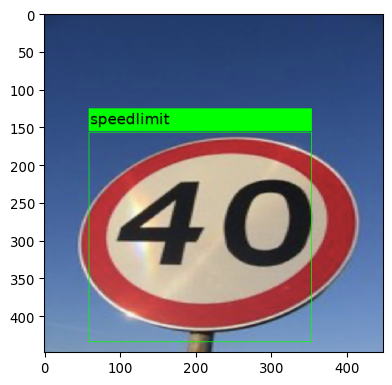

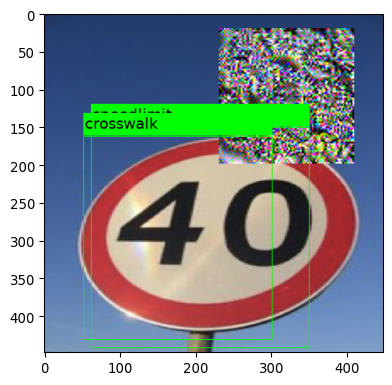

In [79]:
pred_image, pred_boxes, pred_scores, pred_labels, pred_num_detections, pred_conf, pred_labels_proba, coco_results = next(predictions_for_metrics_robust_dpatch1785_plotting)
patched_pred_image, patched_pred_boxes, patched_pred_scores, patched_pred_labels, patched_pred_num_detections, patched_pred_conf, patched_pred_labels_proba, patched_coco_results = next(predictions_for_metrics_robust_dpatch1785_plotting)
ia.imshow(pred_image)
ia.imshow(patched_pred_image)

In [403]:
pred_conf

<tf.Tensor: shape=(14, 14, 2), dtype=float32, numpy=
array([[[1.13682359e-01, 9.24212039e-02],
        [8.36887658e-02, 6.35969639e-02],
        [3.49089205e-02, 2.29164064e-02],
        [1.46959662e-01, 1.24560744e-01],
        [1.56269640e-01, 1.23333246e-01],
        [1.38389826e-01, 1.03531271e-01],
        [6.67049885e-02, 4.68133688e-02],
        [2.51464248e-02, 1.72823966e-02],
        [8.11228156e-03, 5.48118353e-03],
        [6.21799231e-02, 4.65578139e-02],
        [7.16266036e-03, 4.82025743e-03],
        [3.77013981e-02, 2.99896598e-02],
        [1.75342470e-01, 1.56557828e-01],
        [1.47116184e-02, 1.16595328e-02]],

       [[1.17932260e-01, 9.47917998e-02],
        [1.12744659e-01, 8.16864967e-02],
        [3.25715542e-02, 2.10138261e-02],
        [1.11475945e-01, 8.28404725e-02],
        [2.12156296e-01, 1.73617452e-01],
        [2.61199117e-01, 2.08944589e-01],
        [8.05179179e-02, 5.54689467e-02],
        [1.16492510e-02, 6.45497441e-03],
        [6.32032752e-